Input: \
Arrest data was exported on April 10th, 2024, with the lates update of the data on January 18, 2024.\
https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc/about_data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
arrest = pd.read_csv('origdata/NYPD_Arrest_Data__Year_to_Date__20240410.csv'); arrest.head(5)

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,261265483,01/03/2023,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1600500,F,B,49,0,18-24,M,BLACK,1027430,251104,40.855793,-73.843908,POINT (-73.843908 40.855793)
1,261271301,01/03/2023,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,S,120,0,25-44,M,WHITE,962808,174275,40.644996,-74.077263,POINT (-74.077263 40.644996)
2,261336449,01/04/2023,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1601001,F,K,61,0,<18,M,BLACK,995118,155708,40.594054,-73.960866,POINT (-73.960866 40.594054)
3,261328047,01/04/2023,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,Q,114,0,18-24,M,BLACK,1007694,219656,40.769552,-73.915361,POINT (-73.915361 40.769552)
4,261417496,01/05/2023,244.0,"BURGLARY,UNCLASSIFIED,UNKNOWN",107.0,BURGLARY,PL 1402000,F,B,44,0,25-44,F,BLACK,1007174,239542,40.824135,-73.917170,POINT (-73.91717 40.824135)


## Preprocessing

In [3]:
print(arrest.columns)
arrest = arrest[['ARREST_KEY', 'ARREST_DATE', 'OFNS_DESC', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT',
       'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD',
       'Y_COORD_CD', 'Latitude', 'Longitude', 'New Georeferenced Column']]

Index(['ARREST_KEY', 'ARREST_DATE', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC',
       'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT',
       'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD',
       'Y_COORD_CD', 'Latitude', 'Longitude', 'New Georeferenced Column'],
      dtype='object')


### Sanity Check

In [4]:
# check if the unqiue values of ARREST_BORO are corresponding to 5 boroughs: K represents Brooklyn based on the data dictionary
print(arrest.ARREST_BORO.unique())

['B' 'S' 'K' 'Q' 'M']


The shape of original data is: (226872, 15)



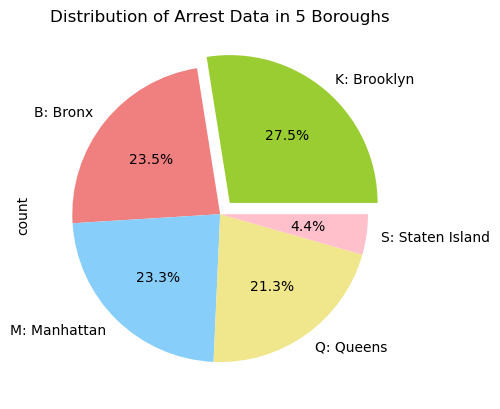


The shape of Brooklyn data is: (62395, 15), which is around 27.5% of original data


In [5]:
print('The shape of original data is:', arrest.shape)
print()
# Plotting the pie chart
plt.figure()
labels = ['K: Brooklyn', 'B: Bronx', 'M: Manhattan', 'Q: Queens', 'S: Staten Island']
colors = ['yellowgreen', 'lightcoral', 'lightskyblue', 'khaki', 'pink']
explode = (0.1, 0, 0, 0, 0)  
arrest['ARREST_BORO'].value_counts().plot(kind='pie', autopct='%1.1f%%', explode=explode, colors=colors, labels=labels)
plt.title('Distribution of Arrest Data in 5 Boroughs')

plt.show()
print()

arrest_bk = arrest[arrest.ARREST_BORO == 'K']
print(f'The shape of Brooklyn data is: {arrest_bk.shape}, which is around {round(100*(arrest_bk.shape[0]/arrest.shape[0]), 2)}% of original data')

In [6]:
# filter out those with either OFNS_DESC or LAW_CAT_CD are equal to '(null)'
if len(arrest_bk[((arrest_bk.OFNS_DESC == '(null)') | (arrest_bk.LAW_CAT_CD == '(null)'))]) > 0:
    arrest_bk = arrest_bk[~((arrest_bk.OFNS_DESC == '(null)') | (arrest_bk.LAW_CAT_CD == '(null)'))]
    print('After fileter out those with either OFNS_DESC or LAW_CAT_CD equal to \'(null)\', the shape is:', arrest_bk.shape)
# filter out those with both OFNS_DESC and LAW_CAT_CD be null values
if len(arrest_bk[((arrest_bk.OFNS_DESC.isnull()) & (arrest_bk.LAW_CAT_CD.isnull()))]):
    arrest_bk = arrest_bk[~((arrest_bk.OFNS_DESC.isnull()) & (arrest_bk.LAW_CAT_CD.isnull()))]
    print('After fileter out those with both OFNS_DESC and LAW_CAT_CD be null values, the shape is:', arrest_bk.shape)
# filter out those LAW_CAT_CD == '9'
if len(arrest_bk[arrest_bk.LAW_CAT_CD == '9']) > 0:
    arrest_bk = arrest_bk[arrest_bk.LAW_CAT_CD != '9']
    print('After fileter out those LAW_CAT_CD == \'9\', the shape is:', arrest_bk.shape)

# combining V and I into one category V/I in column LAW_CAT_CD
arrest_bk['LAW_CAT_CD'] = arrest_bk['LAW_CAT_CD'].replace({'V': 'V/I', 'I': 'V/I'})

After fileter out those with either OFNS_DESC or LAW_CAT_CD equal to '(null)', the shape is: (62390, 15)
After fileter out those LAW_CAT_CD == '9', the shape is: (62378, 15)


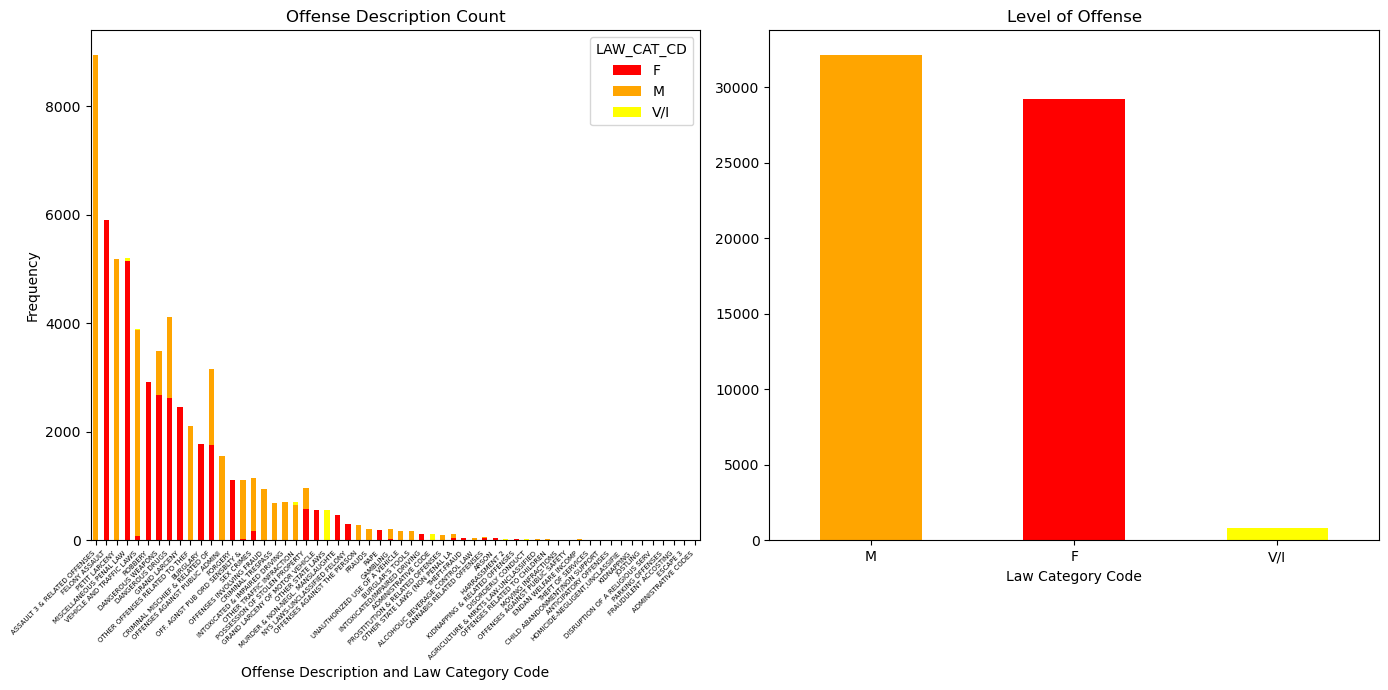

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

grouped = arrest_bk.groupby(['OFNS_DESC','LAW_CAT_CD']).size().sort_values(ascending=False).unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True, color=['r','orange','yellow'], ax=axes[0])
axes[0].set_title('Offense Description Count')
axes[0].set_xlabel('Offense Description and Law Category Code')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', which='major', labelsize=5)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

arrest_bk['LAW_CAT_CD'].value_counts().plot(kind='bar', color=['orange','r','yellow'], ax=axes[1])
axes[1].set_title('Level of Offense')
axes[1].set_xlabel('Law Category Code')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()

plt.show()

In [29]:
arrest['ARREST_DATE'].dt.year.unique()

array([2023])

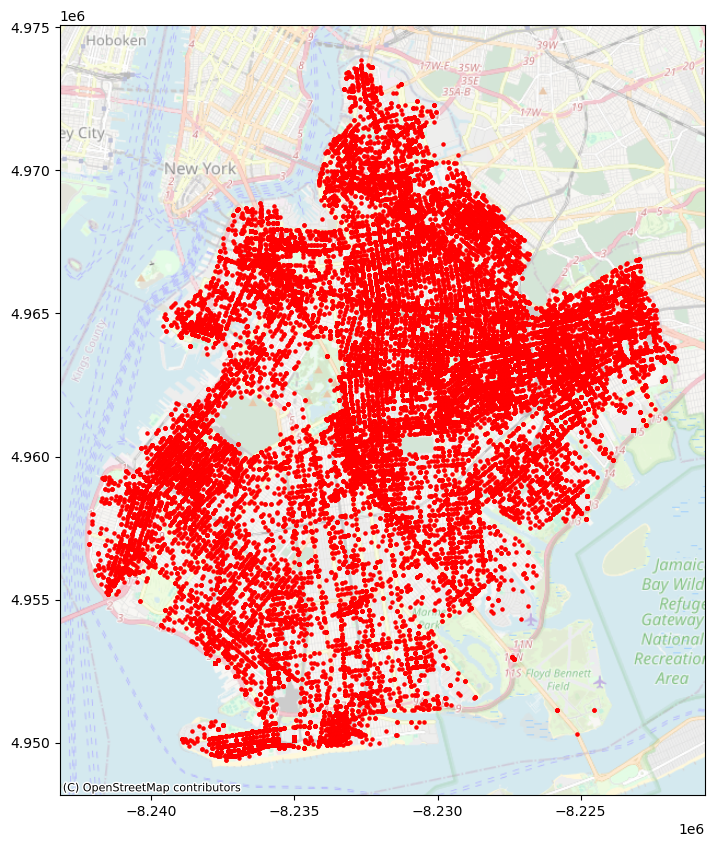

In [37]:
from shapely.geometry import Point
import contextily as ctx

gdf = gpd.GeoDataFrame(arrest_bk, geometry=gpd.points_from_xy(arrest_bk['Longitude'], arrest_bk['Latitude']))

gdf.set_crs(epsg=4326, inplace=True)
#gdf['color'] = ['red' if x == 'K' else 'black' for x in arrest.ARREST_BORO]
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='red', markersize=5)  # Adjust 'markersize' to change the point size

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

#plt.xlim(-74.25, -73.7)
#plt.ylim(40.5, 40.9)

plt.show()

In [ ]:
arrest_bk.OFNS_DESC.value_counts()

In [ ]:
arrest_bk.LAW_CAT_CD.value_counts()